In [1]:
import os
from os import path
import urllib.request
import gzip
import struct
import array

import jax
import syft as sy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# relative import
from mnist_dataset import mnist, mnist_raw


print(f"{sy.__version__ = }")

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/dk/Desktop/projects/PySyft



Warning: syft is imported in light mode by default.         
To switch to dark mode, please run `sy.options.color_theme = 'dark'`

sy.__version__ = '0.8.1-beta.12'


## 1. Launch the domain, upload the data

In [2]:
node = sy.orchestra.launch(name="dk-domain", dev_mode=True, reset=True)
root_client = node.login(email="info@openmined.org", password="changethis")

SQLite Store Path:
!open file:///tmp/7394e1ec94664623a12883a6a2443efa.sqlite

Logged into dk-domain as GUEST
Logged into dk-domain as <info@openmined.org>


### Load the MNIST dataset

Let's load the raw MNIST images and show with the `mnist_raw` function from `datasets.py`

In [3]:
train_images, train_labels, _, _ = mnist_raw()

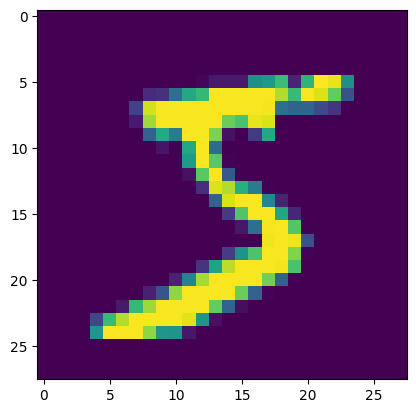

In [4]:
plt.imshow(train_images[0])

In [5]:
train_labels[0]

5

In [6]:
print(f"{train_images.shape = }")
print(f"{train_labels.shape = }")

train_images.shape = (60000, 28, 28)
train_labels.shape = (60000,)


### Processing: Flattening the MNIST images and apply one-hot encoding on the labels

In [7]:
train_images, train_labels, _, _ = mnist()

### Get a subset of MNIST

In [8]:
num_samples = 1000

In [9]:
train_images = train_images[:num_samples, :] 
train_labels = train_labels[:num_samples, :]

In [10]:
print(f"{train_images.shape = }")
print(f"{train_labels.shape = }")

train_images.shape = (1000, 784)
train_labels.shape = (1000, 10)


The `train_images` and `train_labels` are the private data. Let's create similar mock data with the same shape

In [11]:
mock_images = np.random.rand(num_samples, 784)
mock_images.shape

(1000, 784)

In [12]:
mock_labels = np.eye(10)[np.random.choice(10, num_samples)]
mock_labels.shape

(1000, 10)

In [13]:
assert mock_labels.shape == train_labels.shape
assert mock_images.shape == train_images.shape

### The DO uploads the data

In [14]:
dataset = sy.Dataset(
    name="MNIST data",
    description="""Contains the flattened training images and one-hot encoded training labels.""",
    url="https://storage.googleapis.com/cvdf-datasets/mnist/"
)

dataset.add_contributor(role=sy.roles.UPLOADER, 
                        name="Alice", 
                        email="alice@openmined.com",
                        note="Alice is the data engineer at the OpenMined")

dataset.contributors

[syft.service.dataset.dataset.Contributor]

In [15]:
asset_mnist_train_input = sy.Asset(
    name="MNIST training images",
    description="""The training images of the MNIST dataset""",
    data=train_images,
    mock=mock_images
)

asset_mnist_train_labels = sy.Asset(
    name="MNIST training labels",
    description="""The training labels of MNIST dataset""",
    data=train_labels,
    mock=mock_labels
)

dataset.add_asset(asset_mnist_train_input)
dataset.add_asset(asset_mnist_train_labels)

In [16]:
root_client.upload_dataset(dataset)

  0%|                                                                                                                         | 0/2 [00:00<?, ?it/s]

Uploading: MNIST training images


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.53it/s]


Uploading: MNIST training labels


<class 'syft.service.response.SyftSuccess'>: Dataset Added

### The DO inspects the uploaded data

In [17]:
datasets = root_client.api.services.dataset.get_all()
assert len(datasets) == 1
datasets

[syft.service.dataset.dataset.Dataset]

#### The first asset of the dataset contains the training and mock images

In [18]:
datasets[0].assets[0]

syft.service.dataset.dataset.Asset

#### The second asset contains the training and mock labels

In [19]:
datasets[0].assets[1]

syft.service.dataset.dataset.Asset

### The DO creates an account for the Data Scientist (DS)

In [20]:
root_client.register(name="Sheldon Cooper",
                     email="sheldon@caltech.edu",
                     password="changethis",
                     institution="Caltech",
                     website="https://www.caltech.edu/")

<class 'syft.service.response.SyftSuccess'>: User Sheldon Cooper successfully registered! To see users, run client.users.

### 📓 Now switch to the DS's notebook

## 2. After the DS submits code execution requests, DO review and approve the code

In [21]:
root_client.projects

In [22]:
requests = root_client.projects[0].requests
requests

[syft.service.request.request.Request]

In [23]:
request = requests[0]
request

syft.service.request.request.Request

In [24]:
change = request.changes[0]
change

```python
class UserCodeStatusChange:
  id: 03d2c634e5594339b80662f901936351
  function: mnist_3_linear_layers
  input_policy_type: ExactMatch
  output_policy_type: OutputPolicyExecuteOnce
  approved: False
```

In [25]:
# gettting a reference to the user code object
user_code = change.link

# viewing the actual code submitted for request
print(user_code.code)

@sy.syft_function(input_policy=sy.ExactMatch(mnist_images=mock_images_ptr, mnist_labels=mock_labels_ptr),
                  output_policy=sy.SingleExecutionExactOutput())
def mnist_3_linear_layers(mnist_images, mnist_labels):
    # import the packages
    import jax
    from jax.example_libraries import stax
    from jax.example_libraries.stax import Dense, Relu, LogSoftmax
    import time
    from jax.example_libraries import optimizers
    import itertools
    import jax.numpy as jnp
    import numpy.random as npr
    from jax import jit, grad, random
    
    # define the neural network
    init_random_params, predict = stax.serial(
        Dense(1024), Relu,
        Dense(1024), Relu,
        Dense(10), LogSoftmax)
    
    # initialize the random parameters
    rng = random.PRNGKey(0)
    _, init_params = init_random_params(rng, (-1, 784))
    
    # the hyper parameters
    num_epochs = 10
    batch_size = 4
    num_train = mnist_images.shape[0]
    num_complete_batches, leftover

In [26]:
user_code.assets

[syft.service.dataset.dataset.Asset, syft.service.dataset.dataset.Asset]

In [27]:
users_function = user_code.unsafe_function
users_function

<function syft.service.code.user_code.UserCode.unsafe_function.<locals>.wrapper(*args: 'Any', **kwargs: 'Any') -> 'Callable'>

In [28]:
mock_images = user_code.assets[0].mock
print(f"{mock_images.shape = }")
mock_labels = user_code.assets[1].mock
print(f"{mock_labels.shape = }")

mock_images.shape = (1000, 784)
mock_labels.shape = (1000, 10)


#### The DO runs the code on mock data to ensure things are fine

In [29]:
mock_train_accs, mock_params = users_function(mnist_images=mock_images, mnist_labels=mock_labels)


Starting training...
Epoch 0 in 2.03 sec
Training set accuracy 0.15700000524520874
Epoch 1 in 1.71 sec
Training set accuracy 0.23900000751018524
Epoch 2 in 1.95 sec
Training set accuracy 0.34700000286102295
Epoch 3 in 1.98 sec
Training set accuracy 0.2580000162124634
Epoch 4 in 1.93 sec
Training set accuracy 0.5550000071525574
Epoch 5 in 1.79 sec
Training set accuracy 0.45100003480911255
Epoch 6 in 2.20 sec
Training set accuracy 0.6100000143051147
Epoch 7 in 1.87 sec
Training set accuracy 0.7460000514984131
Epoch 8 in 1.80 sec
Training set accuracy 0.812000036239624
Epoch 9 in 1.85 sec
Training set accuracy 0.7970000505447388


#### If the DO inspects and checks that things are good, he can execute the code on the private data and then deposit the results to the domain

In [30]:
# private data associated with the asset
private_images = user_code.assets[0].data
print(f"{private_images.shape = }")
private_labels = user_code.assets[1].data
print(f"{private_labels.shape = }")

private_images.shape = (1000, 784)
private_labels.shape = (1000, 10)


In [31]:
train_accs, params = users_function(mnist_images=private_images, mnist_labels=private_labels)


Starting training...
Epoch 0 in 2.21 sec
Training set accuracy 0.8290000557899475
Epoch 1 in 1.76 sec
Training set accuracy 0.8840000629425049
Epoch 2 in 1.89 sec
Training set accuracy 0.9200000166893005
Epoch 3 in 1.78 sec
Training set accuracy 0.937000036239624
Epoch 4 in 1.79 sec
Training set accuracy 0.9530000686645508
Epoch 5 in 2.01 sec
Training set accuracy 0.9670000672340393
Epoch 6 in 1.87 sec
Training set accuracy 0.9770000576972961
Epoch 7 in 1.80 sec
Training set accuracy 0.9780000448226929
Epoch 8 in 1.86 sec
Training set accuracy 0.9900000691413879
Epoch 9 in 1.80 sec
Training set accuracy 0.9970000386238098


In [32]:
# shape of the model's parameters
jax.tree_map(lambda x: x.shape, params)

[((784, 1024), (1024,)),
 (),
 ((1024, 1024), (1024,)),
 (),
 ((1024, 10), (10,)),
 ()]

#### Deposit the results so the DS can get them

In [33]:
res = request.accept_by_depositing_result((train_accs, params))

In [34]:
res

<class 'syft.service.response.SyftSuccess'>: Request a2a19b08387e4d69ac86721dea40b8d1 changes applied

### 📓 Now switch to the DS's notebook